## Analyse des variations de plans vidéos 

### Import des packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [2]:
img_test = cv2.imread('data/images_tests/image1231.jpg')
img_test_grey = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)

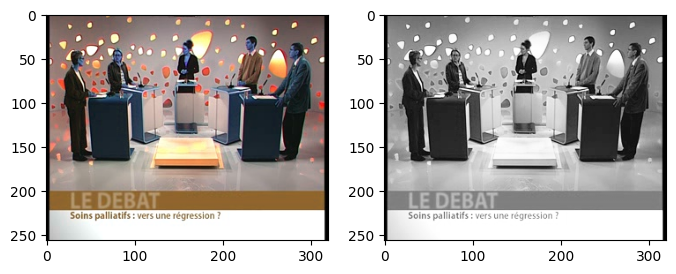

In [3]:
fig, ax = plt.subplots(ncols=2, figsize = (8,12))

ax[0].imshow(img_test)
ax[1].imshow(img_test_grey, cmap = 'Greys_r')

plt.show()

In [4]:
# split + merge est moins efficient qu'une opération directe sur np.array
b, g, r = (img_test[:,:,i] for i in range(3))
tt = np.stack([r, g, b], axis=-1)

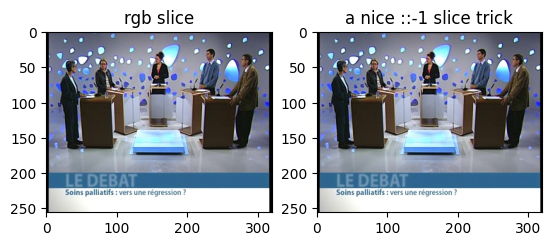

In [5]:
_, ax = plt.subplots(ncols=2)
ax[0].set_title("rgb slice")
ax[0].imshow(tt)
ax[1].set_title("a nice ::-1 slice trick")
ax[1].imshow(img_test[:,:,::-1])
plt.show()

In [10]:
def sort_alphanum( l: list ) -> list:
    """ Sort the given iterable in the way that humans expect.
    courtesy from Mark Byers & Jeff Atwood
    https://stackoverflow.com/questions/2669059/how-to-sort-alpha-numeric-set-in-python
    
    Args:
        l (list): liste alphanumérique à ordonner

    Returns:
        list: liste arrangée par ordre alphanumérique.
    """    

    import re
    
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)


images_list = sort_alphanum(glob("data/images_tests/*"))

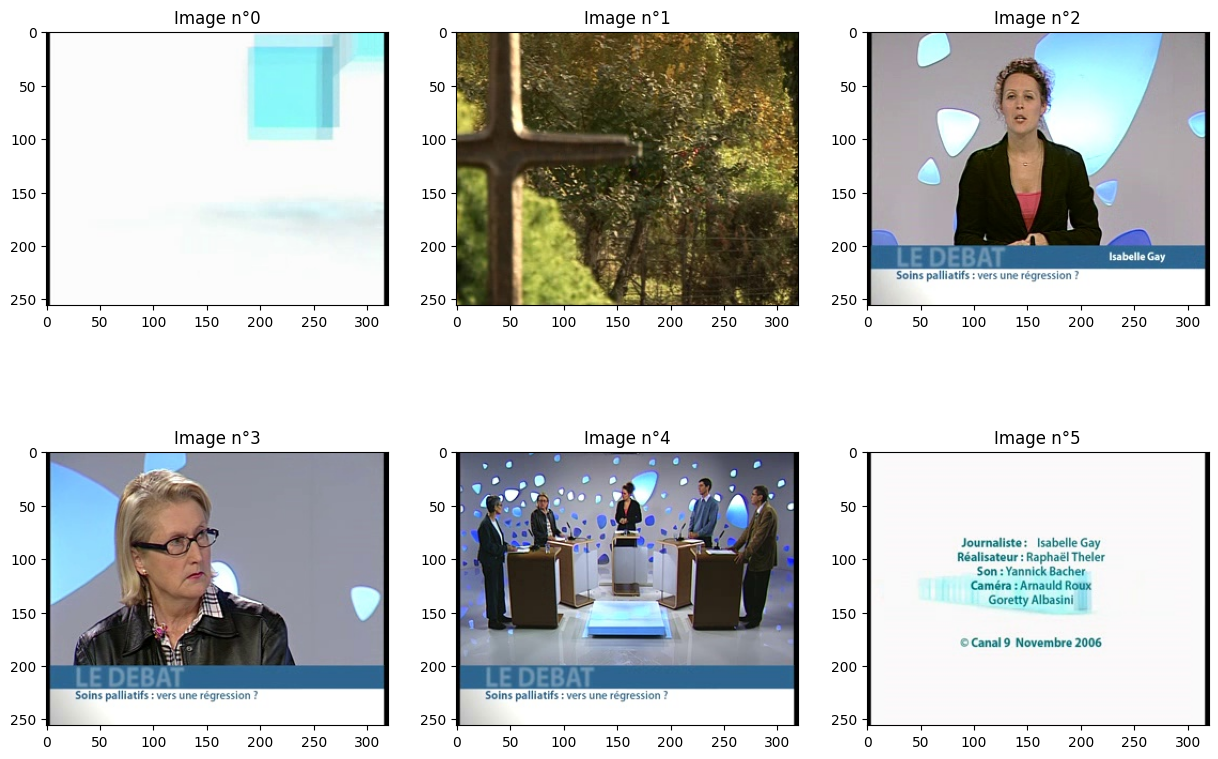

In [7]:
tt = np.array( [cv2.imread(x) for x in images_list] )[:,:,:,::-1] # meilleur performance à reordonner les BGR en RGB avec ::-1
tt.shape # 6 images * 256 * 320 * 3

_, axs = plt.subplots(2, 3, figsize=(15,10))

for i, ax in enumerate(axs.flatten()): # axs est de type 2d array, un flatten/ravel/reshape(-1) le transforme en 1d array et permet d'itérer dessus
    ax.set_title(f"Image n°{i}")
    ax.imshow(tt[i])

plt.show()

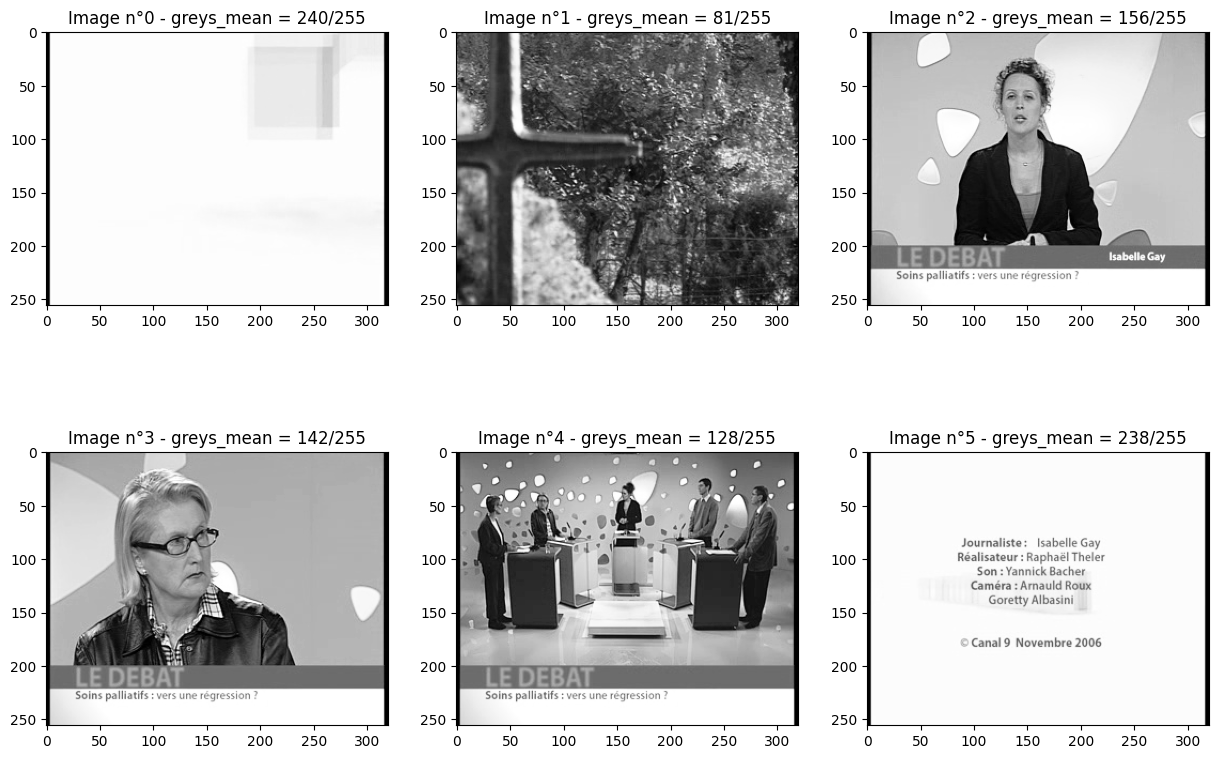

In [8]:
ttg = np.array( [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY) for x in images_list] ) # [:,:,:,::-1]
ttg.shape # 6 images * 256 * 320 * 3 ->  6 images * 256 * 320 * 1 dimension de couleur après conversion en gris

# calcul des moyennes de gris
grey_means = np.apply_over_axes(np.mean, axes=[1,2], a=ttg).ravel()

_, axs = plt.subplots(2, 3, figsize=(15,10))

for i, ax in enumerate(axs.reshape(-1)): # axs est de type 2d array, un reshape(-1) le transforme en 1d array et permet d'itérer dessus
    ax.set_title(f"Image n°{i} - greys_mean = {grey_means[i]:.0f}/255")
    ax.imshow(ttg[i], cmap='Greys_r') # on précise le cmap en nuance de gris pour ne pas avoir le RGB habituel (ici des nuances de vert ??)

plt.show()

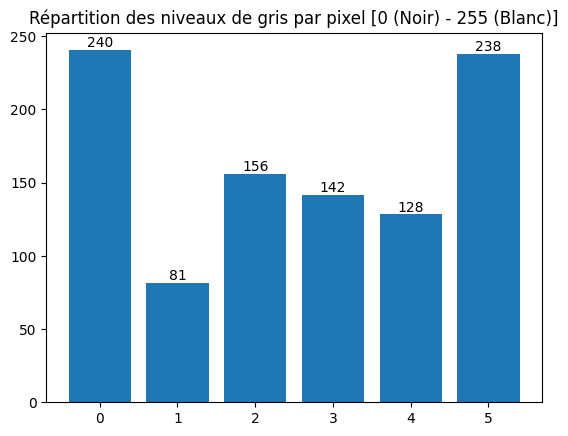

In [9]:
fig, ax = plt.subplots()

ax.set_title("Répartition des niveaux de gris par pixel [0 (Noir) - 255 (Blanc)]")
ax.bar(range(6), grey_means)

for i,j in enumerate(grey_means):
    ax.text(i, j, f"{j:.0f}", horizontalalignment="center", verticalalignment="bottom")

plt.show()

In [55]:
from os import listdir
import pandas as pd
import numpy as np

# df = pd.DataFrame({"image_id": sort_alphanum( listdir("data/test_extract") )} ).assign(grey_mean = np.random.randint(0, 255, 4702))
# path = "data/images_tests"
path = "data/test_extract"
df = pd.DataFrame({"image_path": sort_alphanum( glob(f"{path}/*.jpg") ), "image_id": sort_alphanum( listdir(path) ) } )

# --- on calcule pour chaques images la projection sur le plan gris de chaques pixels : 256*320*3 --> 256*320(*1)
greys = df.image_path.apply(lambda x: cv2.cvtColor(cv2.imread( x ), cv2.COLOR_BGR2GRAY) )
# greys.apply(lambda x: x.shape)

greys_stat = greys.apply(lambda x: pd.Series( (np.min(x), np.median(x), np.mean(x), np.max(x)), index = ["grey_min", "grey_median", "grey_mean", "grey_max"] ) )

# --- on assemble les résultats ensuite avec pd.concat (plus optimisé que la création une à une des colonnes dans df)
# --- ce code met ~18s à tourner sur l'ensemble des 4 708 images
df = pd.concat([df, greys_stat], axis=1)
del greys_stat, greys
df

,image_path,image_id,grey_min,grey_median,grey_mean,grey_max
0,data/test_extract\image_1.jpg,image_1.jpg,0.0,252.0,245.852368,255.0
1,data/test_extract\image_2.jpg,image_2.jpg,0.0,252.0,240.444470,255.0
2,data/test_extract\image_3.jpg,image_3.jpg,0.0,252.0,238.396594,255.0
3,data/test_extract\image_4.jpg,image_4.jpg,0.0,251.0,235.001331,255.0
4,data/test_extract\image_5.jpg,image_5.jpg,0.0,251.0,233.112976,255.0
...,...,...,...,...,...,...
4697,data/test_extract\image_4698.jpg,image_4698.jpg,0.0,250.0,233.913965,255.0
4698,data/test_extract\image_4699.jpg,image_4699.jpg,26.0,250.0,238.985193,254.0
4699,data/test_extract\image_4700.jpg,image_4700.jpg,192.0,252.0,249.972864,254.0
4700,data/test_extract\image_4701.jpg,image_4701.jpg,255.0,255.0,255.000000,255.0
